In [ ]:
#Download pretrained spacy model en_core_web_sm for advanced natural language processing.
!python -m spacy download en_core_web_sm

Import Libraries

In [ ]:
#Import Required Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import nltk
import spacy
from textblob import TextBlob
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('tagsets')

Import Data

In [3]:
%%time
#Import Dataset
df=pd.read_excel("/content/hotel_reviews.xlsx")
df.head()

CPU times: user 2.13 s, sys: 55.3 ms, total: 2.19 s
Wall time: 2.32 s


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4.0
1,ok nothing special charge diamond member hilto...,2.0
2,nice rooms not 4* experience hotel monaco seat...,3.0
3,"unique, great stay, wonderful time hotel monac...",5.0
4,"great stay great stay, went seahawk game aweso...",5.0


Data Understanding

In [4]:
df.shape

(20491, 2)

* Total Observations for the column Review = 20491
* There are two Columns - Review & Rating

In [5]:
df.dtypes

Review     object
Rating    float64
dtype: object

* Review of datatype Object
* Rating is of datatype float64

In [6]:
df.describe().round(3)

,Rating
count,20491.000
mean,3.952
std,1.233
min,1.000
25%,3.000
50%,4.000
75%,5.000
max,5.000


* Total Unique Reviews with Ratings = 20491
* Minimum Rating = 1
* Maximum Rating = 5
* On average, user gives Rating 4

In [7]:
df["Rating"].value_counts()

5.0    9054
4.0    6039
3.0    2184
2.0    1793
1.0    1421
Name: Rating, dtype: int64

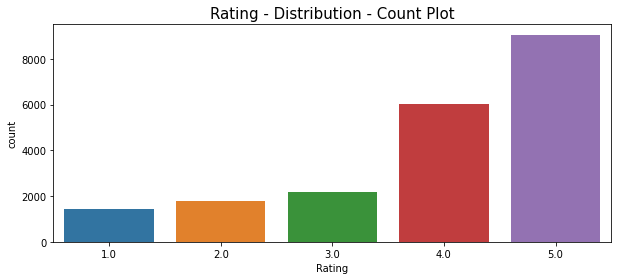

In [8]:
plt.figure(figsize=(10,4))
sns.countplot(x=df.Rating)
plt.title('Rating - Distribution - Count Plot',size=15)
plt.show()

From Count Plot, we can observe that
* More people have given Rating 4 and 5
* Comparitively very less people have given Rating 1,2 and 3
* This shows class Imbalance in the Dataset

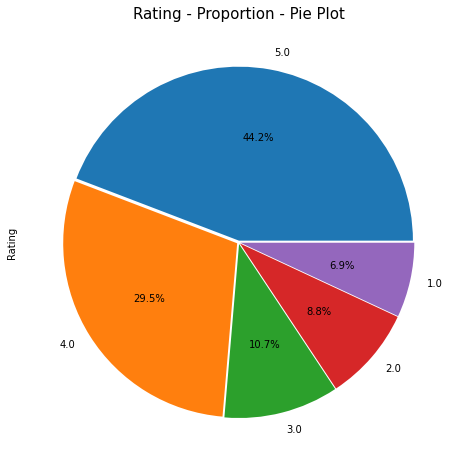

In [9]:
plt.figure(figsize=(8,8))
df.Rating.value_counts().plot(kind='pie',explode=[0.01,0.01,0.01,0.01,0.01],autopct='%.1f%%')
plt.title('Rating - Proportion - Pie Plot',size=15)
plt.show()

From Pie Plot, we can observe that
* 44.2 % of the people have given Rating 5
* 29.5% of the people have given Rating 4
* Only 6.9 % of the people have given Rating 1
* This shows that Ratings are not in same proportion

In [10]:
def rating_analysis(rating):
  if rating==1 or rating ==2:
    return 'Negative'
  elif rating==4 or rating ==5:
    return 'Positive'
  else:
    return 'Neutral'

df['Rating_Analysis']=df['Rating'].apply(lambda x : rating_analysis(x))
df['Rating_Analysis'].value_counts()

Positive    15093
Negative     3214
Neutral      2184
Name: Rating_Analysis, dtype: int64

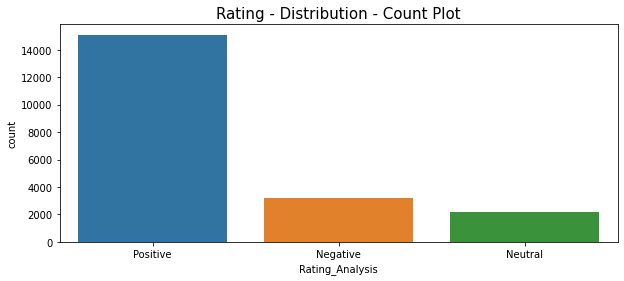

In [11]:
plt.figure(figsize=(10,4))
sns.countplot(x=df['Rating_Analysis'])
plt.title('Rating - Distribution - Count Plot',size=15)
plt.show()

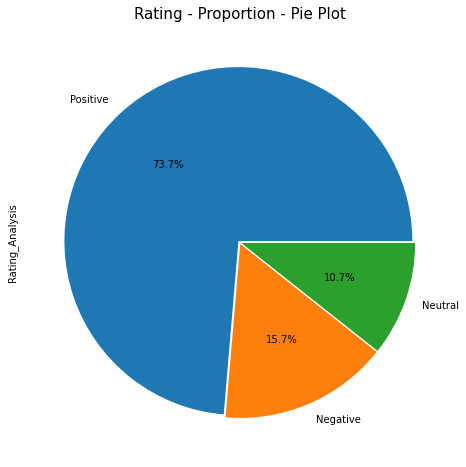

In [12]:
plt.figure(figsize=(8,8))
df['Rating_Analysis'].value_counts().plot(kind='pie',explode=[0.01,0.01,0.01],autopct='%.1f%%')
plt.title('Rating - Proportion - Pie Plot',size=15)
plt.show()

In [13]:
df.isnull().sum()

Review             0
Rating             0
Rating_Analysis    0
dtype: int64

* There is no null or missing entries in both the columns Review and Rating

In [14]:
count=df.isnull().sum().sort_values(ascending=True)
count

Review             0
Rating             0
Rating_Analysis    0
dtype: int64

In [15]:
percentage=((df.isnull().sum()/len(df)*100))
percentage

Review             0.0
Rating             0.0
Rating_Analysis    0.0
dtype: float64

In [16]:
missing_data=pd.concat([count,percentage],axis=1,keys=["Count","Percentage"])
missing_data

,Count,Percentage
Review,0,0.0
Rating,0,0.0
Rating_Analysis,0,0.0


In [17]:
df[df['Review'].duplicated()]

,Review,Rating,Rating_Analysis


* There is no duplicate observations in the dataset

In [18]:
df['Review'].unique()[1000]

'shame hotel wasnt good restaurant, arrived clift late afternoon struggle luggage 3 bags, reception staff unhelpful uninterested, eventually managed sorted shown room 9th floor, room suite tried make separate living room putting curtain inbetween bedroom living room, bathroom tiny dirty, stayed mum unfortunatley night didnt feel suffering bad foot, decided phone reception ask doctor come hotel told ther wasnt local receptionist closest told phone, eventually decided hospital just safe, came hospital evening doormen talking girls outside let, following night ate hotel restaurant aisa cuba fantastic, think hotel intrest restaurant bar, end day sleeping ignored wouldnt stay,  '

Exploratory Data Analysis

In [19]:
#stop_words = stopwords.words('english')

In [20]:
stop_words = pd.read_csv('/content/stop.txt',header=None,squeeze=True)
stop_words

0               a
1             a's
2            able
3           about
4           above
          ...    
566         yours
567      yourself
568    yourselves
569             z
570          zero
Name: 0, Length: 571, dtype: object

In [21]:
def text_clean(text):
  """
  This Function make the text into lower case, remove punctuations, urls, escape sequences, etc.
  """
  text=text.lower()
  text=re.sub("\[.*?\]","",text)
  text=re.sub('\S*https?:\S*',"",text)
  text=re.sub("[%s]" % re.escape(string.punctuation),"",text)
  text=re.sub("\w*\d\w*","",text)
  text=re.sub("\n","",text)
  text=re.sub(' +', " ", text)
  return text
clean=lambda x : text_clean(x)

In [22]:
%%time
df['Cleaned_Review'] = df['Review'].apply(clean)
df.head()

CPU times: user 3.59 s, sys: 27.8 ms, total: 3.62 s
Wall time: 3.63 s


,Review,Rating,Rating_Analysis,Cleaned_Review
0,nice hotel expensive parking got good deal sta...,4.0,Positive,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2.0,Negative,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3.0,Neutral,nice rooms not experience hotel monaco seattle...
3,"unique, great stay, wonderful time hotel monac...",5.0,Positive,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5.0,Positive,great stay great stay went seahawk game awesom...


Word Frequency - Before Removing Stop Words

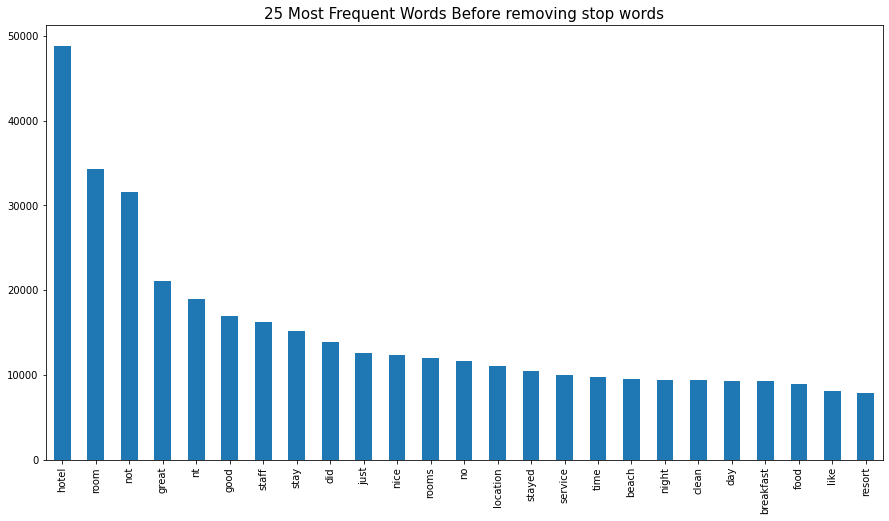

In [23]:
word_freq_1=pd.Series(" ".join(df['Cleaned_Review']).split()).value_counts()[:25]
word_freq_1.plot(kind='bar',figsize=(15,8))
plt.title('25 Most Frequent Words Before removing stop words',size=15)
plt.show()

Adding new word 'nt' to the stop words list, so that it will be removed.

In [24]:
additional_stop_words = ['nt']
stop_words=stop_words.append(pd.Series(additional_stop_words),ignore_index = True)
stop_words

0               a
1             a's
2            able
3           about
4           above
          ...    
567      yourself
568    yourselves
569             z
570          zero
571            nt
Length: 572, dtype: object

In [25]:
%%time
df['Cleaned_Review']=df['Cleaned_Review'].apply(lambda x: " ".join(x for x in x.split() if x not in list(stop_words)))
df.head()

CPU times: user 1min 41s, sys: 354 ms, total: 1min 41s
Wall time: 1min 48s


,Review,Rating,Rating_Analysis,Cleaned_Review
0,nice hotel expensive parking got good deal sta...,4.0,Positive,nice hotel expensive parking good deal stay ho...
1,ok nothing special charge diamond member hilto...,2.0,Negative,special charge diamond member hilton decided c...
2,nice rooms not 4* experience hotel monaco seat...,3.0,Neutral,nice rooms experience hotel monaco seattle goo...
3,"unique, great stay, wonderful time hotel monac...",5.0,Positive,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5.0,Positive,great stay great stay seahawk game awesome dow...


Word Frequency After Removing Stop Words

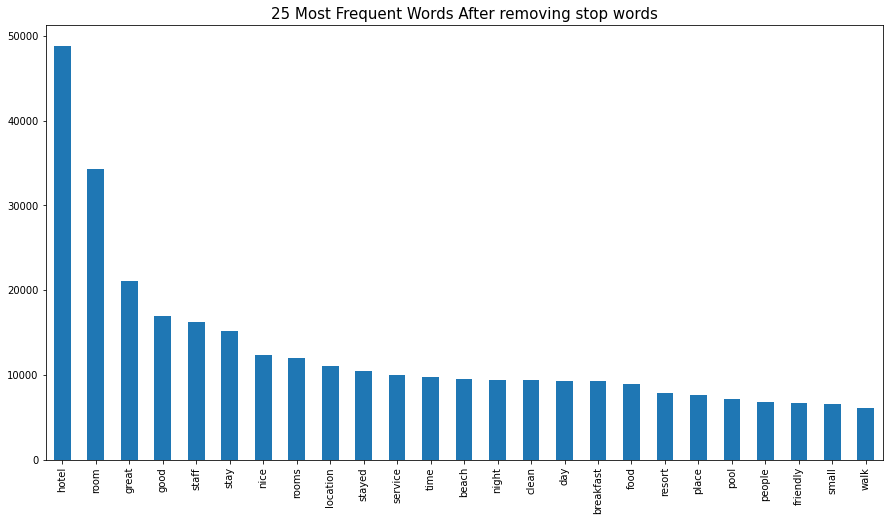

In [26]:
word_freq_2=pd.Series(" ".join(df['Cleaned_Review']).split()).value_counts()[:25]
word_freq_2.plot(kind='bar',figsize=(15,8))
fig=plt.title('25 Most Frequent Words After removing stop words',size=15)
plt.show()

From the Bar plot, we can observe that
* Most freqently used Stop words that are unmeaningfull have been removed

Lemmatization

In [27]:
lemmatizer = WordNetLemmatizer()
w_tokenizer=WhitespaceTokenizer()

In [28]:
def lemmatize(txt):
  """
  This function takes text string as input lemmatize it to its root/base/stem word.
  """
  list_review=[lemmatizer.lemmatize(word=word, pos=tag[0].lower()) if tag[0].lower() in ['a','r','n','v'] else word for word, tag in pos_tag(w_tokenizer.tokenize(txt))]
  return (' '.join([x for x in list_review if x]))

In [29]:
%%time
df['Lemmatized_Review']=df['Cleaned_Review'].apply(lambda x: lemmatize(x))
df.head()

CPU times: user 1min 49s, sys: 779 ms, total: 1min 50s
Wall time: 1min 50s


,Review,Rating,Rating_Analysis,Cleaned_Review,Lemmatized_Review
0,nice hotel expensive parking got good deal sta...,4.0,Positive,nice hotel expensive parking good deal stay ho...,nice hotel expensive parking good deal stay ho...
1,ok nothing special charge diamond member hilto...,2.0,Negative,special charge diamond member hilton decided c...,special charge diamond member hilton decide ch...
2,nice rooms not 4* experience hotel monaco seat...,3.0,Neutral,nice rooms experience hotel monaco seattle goo...,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5.0,Positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5.0,Positive,great stay great stay seahawk game awesome dow...,great stay great stay seahawk game awesome dow...


Review Before Lemmatization

In [30]:
df['Cleaned_Review'][1000]

'shame hotel wasnt good restaurant arrived clift late afternoon struggle luggage bags reception staff unhelpful uninterested eventually managed sorted shown room floor room suite make separate living room putting curtain inbetween bedroom living room bathroom tiny dirty stayed mum unfortunatley night didnt feel suffering bad foot decided phone reception doctor hotel told ther wasnt local receptionist closest told phone eventually decided hospital safe hospital evening doormen talking girls night ate hotel restaurant aisa cuba fantastic hotel intrest restaurant bar end day sleeping wouldnt stay'

In [31]:
len(word_tokenize(df['Cleaned_Review'][1000]))

84

In [32]:
len(df['Cleaned_Review'][1000])

599

check for length of words that are lemmatized...

Review After Lemmatization

In [33]:
df['Lemmatized_Review'][1000]

'shame hotel wasnt good restaurant arrive clift late afternoon struggle luggage bags reception staff unhelpful uninterested eventually manage sort show room floor room suite make separate living room put curtain inbetween bedroom living room bathroom tiny dirty stay mum unfortunatley night didnt feel suffer bad foot decide phone reception doctor hotel tell ther wasnt local receptionist closest tell phone eventually decide hospital safe hospital even doorman talk girl night eat hotel restaurant aisa cuba fantastic hotel intrest restaurant bar end day sleep wouldnt stay'

In [34]:
len(word_tokenize(df['Lemmatized_Review'][1000]))

84

In [35]:
len(df['Lemmatized_Review'][1000])

573

By applying lemmatization, we can observe that
* Number of words in the Review are retained
* Number of Characters in the Review have been reduced from 599 to 573.
* For ex: Words like 'arrived' and 'talking' are converted to 'arrive' and 'talk'.
* They are converted to their base/root/stem words.

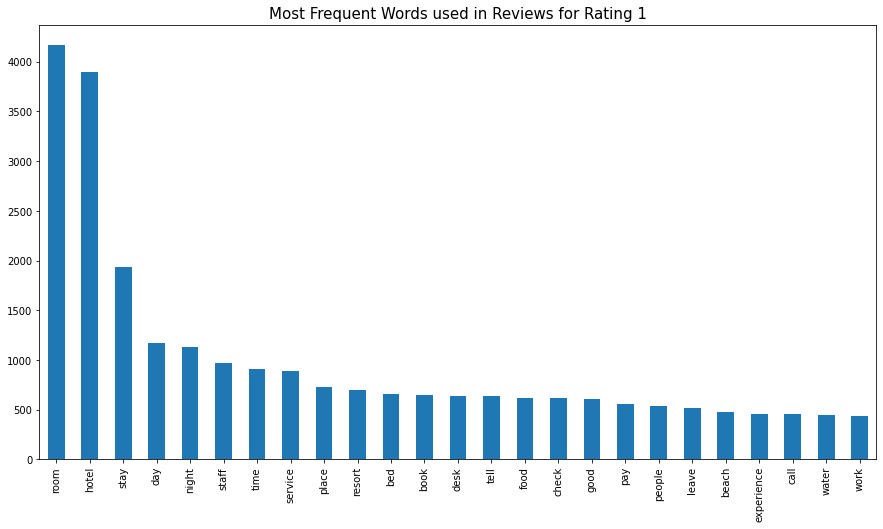

In [36]:
word_freq_rating_1=pd.Series(" ".join(df[df['Rating']==1]['Lemmatized_Review']).split()).value_counts()[:25]
word_freq_rating_1.plot(kind='bar',figsize=(15,8))
plt.title('Most Frequent Words used in Reviews for Rating 1',size=15)
plt.show()

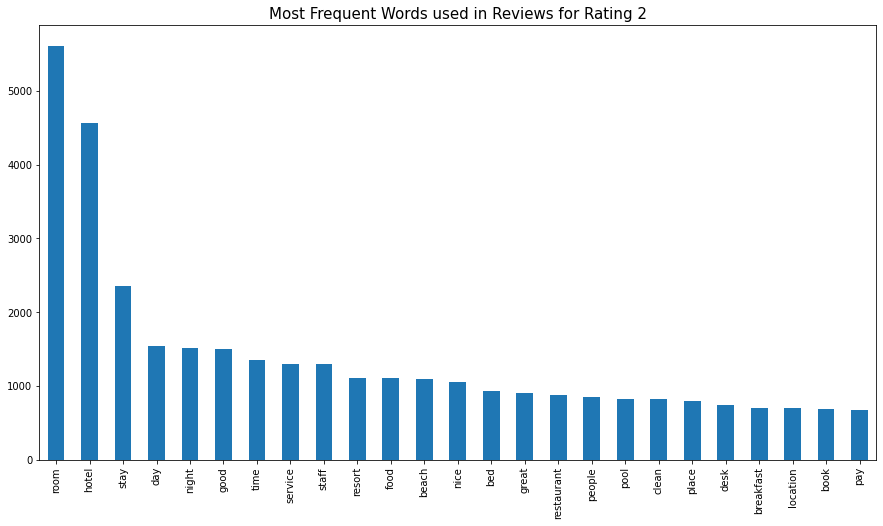

In [37]:
word_freq_rating_2=pd.Series(" ".join(df[df['Rating']==2]['Lemmatized_Review']).split()).value_counts()[:25]
word_freq_rating_2.plot(kind='bar',figsize=(15,8))
plt.title('Most Frequent Words used in Reviews for Rating 2',size=15)
plt.show()

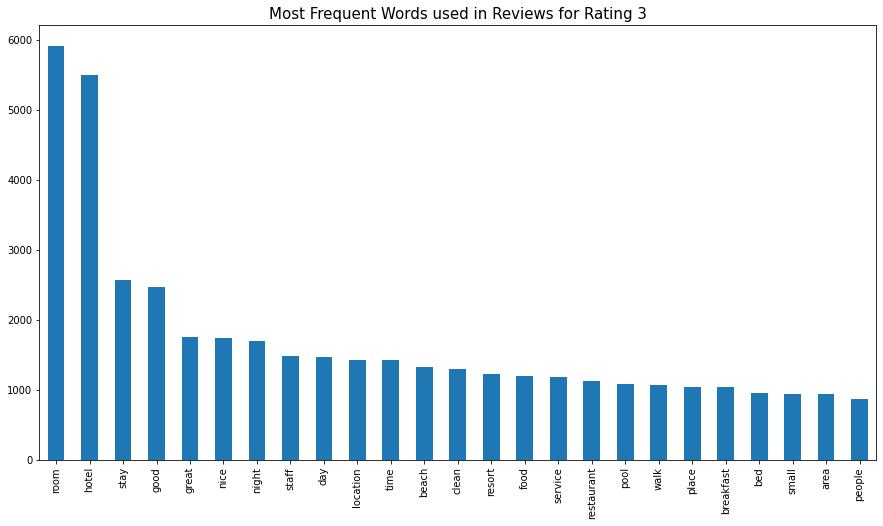

In [38]:
word_freq_rating_3=pd.Series(" ".join(df[df['Rating']==3]['Lemmatized_Review']).split()).value_counts()[:25]
word_freq_rating_3.plot(kind='bar',figsize=(15,8))
plt.title('Most Frequent Words used in Reviews for Rating 3',size=15)
plt.show()

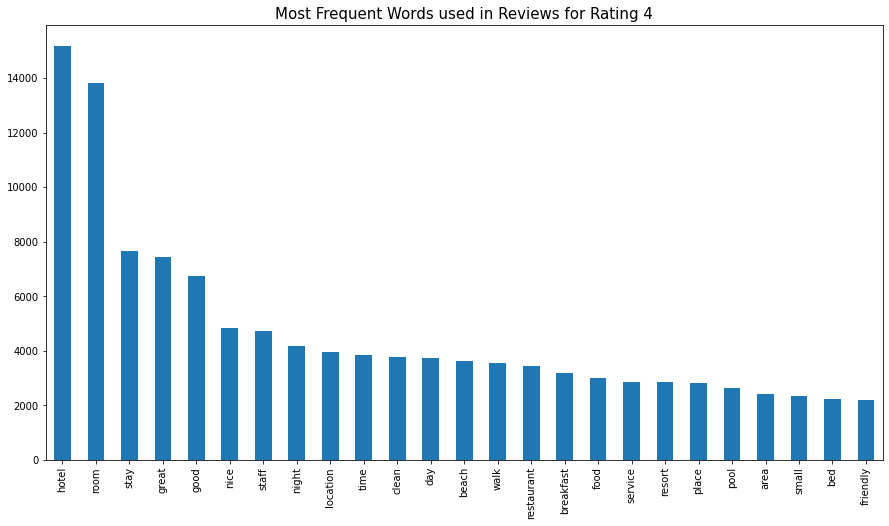

In [39]:
word_freq_rating_4=pd.Series(" ".join(df[df['Rating']==4]['Lemmatized_Review']).split()).value_counts()[:25]
word_freq_rating_4.plot(kind='bar',figsize=(15,8))
plt.title('Most Frequent Words used in Reviews for Rating 4',size=15)
plt.show()

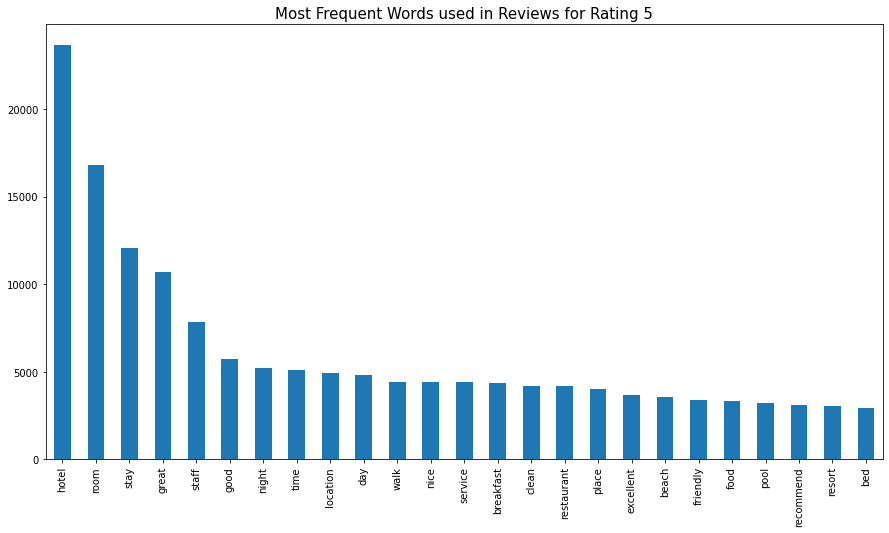

In [40]:
word_freq_rating_5=pd.Series(" ".join(df[df['Rating']==5]['Lemmatized_Review']).split()).value_counts()[:25]
word_freq_rating_5.plot(kind='bar',figsize=(15,8))
plt.title('Most Frequent Words used in Reviews for Rating 5',size=15)
plt.show()

Sentiment Analysis Using TextBlob

In [41]:
%%time
def sentiment_analysis_textblob(review):
  """
  This Function takes review (word/sentence/corpus) as input and find Subjectivity and Polarity
  """
  sentiment=TextBlob(review).sentiment
  return pd.Series([sentiment.subjectivity,sentiment.polarity])
df[['subjectivity','polarity']]=df['Lemmatized_Review'].apply(lambda x : sentiment_analysis_textblob(x))
df.head()

CPU times: user 17 s, sys: 327 ms, total: 17.3 s
Wall time: 17 s


,Review,Rating,Rating_Analysis,Cleaned_Review,Lemmatized_Review,subjectivity,polarity
0,nice hotel expensive parking got good deal sta...,4.0,Positive,nice hotel expensive parking good deal stay ho...,nice hotel expensive parking good deal stay ho...,0.723158,0.229599
1,ok nothing special charge diamond member hilto...,2.0,Negative,special charge diamond member hilton decided c...,special charge diamond member hilton decide ch...,0.534312,0.222302
2,nice rooms not 4* experience hotel monaco seat...,3.0,Neutral,nice rooms experience hotel monaco seattle goo...,nice room experience hotel monaco seattle good...,0.598765,0.341534
3,"unique, great stay, wonderful time hotel monac...",5.0,Positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,0.691228,0.504825
4,"great stay great stay, went seahawk game aweso...",5.0,Positive,great stay great stay seahawk game awesome dow...,great stay great stay seahawk game awesome dow...,0.696753,0.475649


In [42]:
%%time
def polarity_score(score):
  """
  This function takes polarity score found from TextBlob sentiment and try to classify whether the review is Positive/Negative/Neutral
  """
  if score>0:
    return('Positive')
  elif score==0:
    return('Neutral')
  else:
    return('Negative')
df['sentiment_polarity']=df['polarity'].apply(lambda x : polarity_score(x))
df.head()

CPU times: user 7.53 ms, sys: 6 µs, total: 7.54 ms
Wall time: 7.34 ms


,Review,Rating,Rating_Analysis,Cleaned_Review,Lemmatized_Review,subjectivity,polarity,sentiment_polarity
0,nice hotel expensive parking got good deal sta...,4.0,Positive,nice hotel expensive parking good deal stay ho...,nice hotel expensive parking good deal stay ho...,0.723158,0.229599,Positive
1,ok nothing special charge diamond member hilto...,2.0,Negative,special charge diamond member hilton decided c...,special charge diamond member hilton decide ch...,0.534312,0.222302,Positive
2,nice rooms not 4* experience hotel monaco seat...,3.0,Neutral,nice rooms experience hotel monaco seattle goo...,nice room experience hotel monaco seattle good...,0.598765,0.341534,Positive
3,"unique, great stay, wonderful time hotel monac...",5.0,Positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,0.691228,0.504825,Positive
4,"great stay great stay, went seahawk game aweso...",5.0,Positive,great stay great stay seahawk game awesome dow...,great stay great stay seahawk game awesome dow...,0.696753,0.475649,Positive


In [43]:
df['polarity'].describe()

count    20491.000000
mean         0.290467
std          0.198634
min         -1.000000
25%          0.185394
50%          0.301061
75%          0.411881
max          1.000000
Name: polarity, dtype: float64

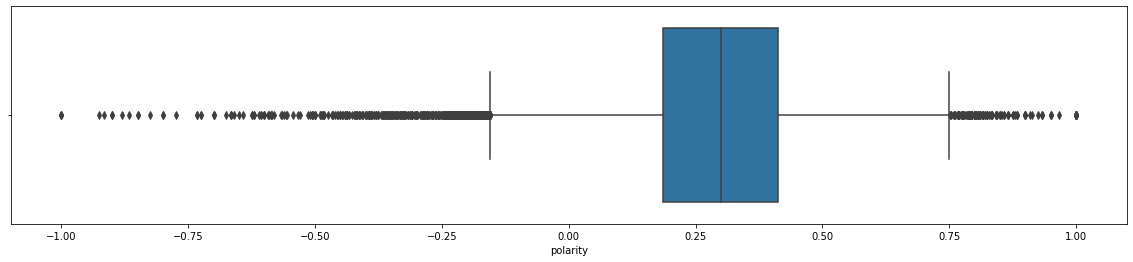

In [44]:
plt.figure(figsize=(20,4))
sns.boxplot(x=df['polarity'])
plt.show()

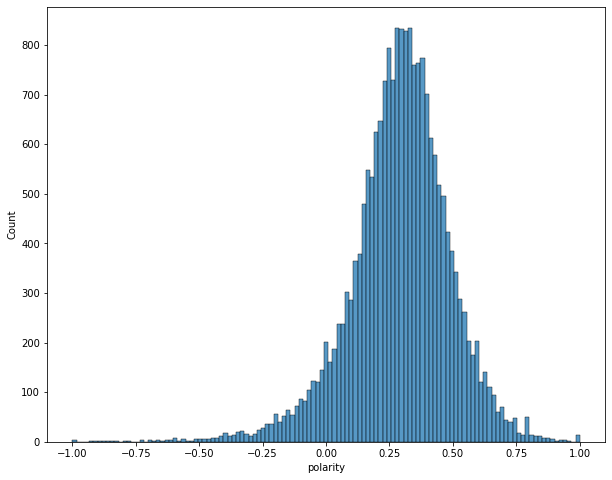

In [45]:
plt.figure(figsize=(10,8))
sns.histplot(df['polarity'])
plt.show()

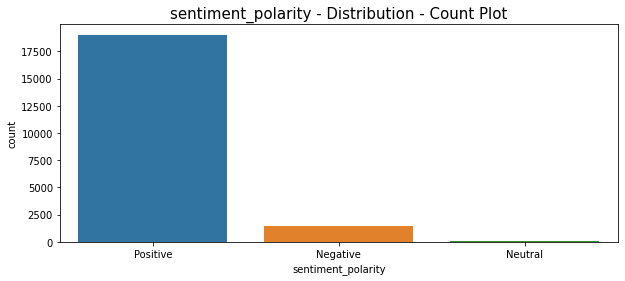

In [46]:
plt.figure(figsize=(10,4))
sns.countplot(x=df.sentiment_polarity)
plt.title('sentiment_polarity - Distribution - Count Plot',size=15)
plt.show()

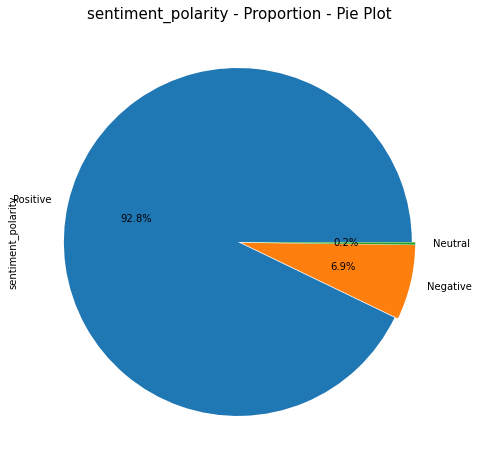

In [47]:
plt.figure(figsize=(8,8))
df.sentiment_polarity.value_counts().plot(kind='pie',explode=[0.01,0.01,0.01],autopct='%.1f%%')
plt.title('sentiment_polarity - Proportion - Pie Plot',size=15)
plt.show()

Sentiment Analysis using Vader Lexicon

In [48]:
SIA = SentimentIntensityAnalyzer()

In [49]:
%%time
df['Vader_Lexicon'] = df['Lemmatized_Review'].apply(lambda x : SIA.polarity_scores(x))
df.head()

CPU times: user 22.3 s, sys: 98 ms, total: 22.4 s
Wall time: 22.4 s


,Review,Rating,Rating_Analysis,Cleaned_Review,Lemmatized_Review,subjectivity,polarity,sentiment_polarity,Vader_Lexicon
0,nice hotel expensive parking got good deal sta...,4.0,Positive,nice hotel expensive parking good deal stay ho...,nice hotel expensive parking good deal stay ho...,0.723158,0.229599,Positive,"{'neg': 0.064, 'neu': 0.608, 'pos': 0.329, 'co..."
1,ok nothing special charge diamond member hilto...,2.0,Negative,special charge diamond member hilton decided c...,special charge diamond member hilton decide ch...,0.534312,0.222302,Positive,"{'neg': 0.049, 'neu': 0.735, 'pos': 0.216, 'co..."
2,nice rooms not 4* experience hotel monaco seat...,3.0,Neutral,nice rooms experience hotel monaco seattle goo...,nice room experience hotel monaco seattle good...,0.598765,0.341534,Positive,"{'neg': 0.048, 'neu': 0.677, 'pos': 0.275, 'co..."
3,"unique, great stay, wonderful time hotel monac...",5.0,Positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,0.691228,0.504825,Positive,"{'neg': 0.0, 'neu': 0.564, 'pos': 0.436, 'comp..."
4,"great stay great stay, went seahawk game aweso...",5.0,Positive,great stay great stay seahawk game awesome dow...,great stay great stay seahawk game awesome dow...,0.696753,0.475649,Positive,"{'neg': 0.078, 'neu': 0.623, 'pos': 0.299, 'co..."


In [50]:
%%time
df=pd.concat([df.drop(['Vader_Lexicon'],axis=1),df['Vader_Lexicon'].apply(pd.Series)],axis=1)
df.head()

CPU times: user 5.91 s, sys: 253 ms, total: 6.17 s
Wall time: 5.83 s


,Review,Rating,Rating_Analysis,Cleaned_Review,Lemmatized_Review,subjectivity,polarity,sentiment_polarity,neg,neu,pos,compound
0,nice hotel expensive parking got good deal sta...,4.0,Positive,nice hotel expensive parking good deal stay ho...,nice hotel expensive parking good deal stay ho...,0.723158,0.229599,Positive,0.064,0.608,0.329,0.9769
1,ok nothing special charge diamond member hilto...,2.0,Negative,special charge diamond member hilton decided c...,special charge diamond member hilton decide ch...,0.534312,0.222302,Positive,0.049,0.735,0.216,0.9904
2,nice rooms not 4* experience hotel monaco seat...,3.0,Neutral,nice rooms experience hotel monaco seattle goo...,nice room experience hotel monaco seattle good...,0.598765,0.341534,Positive,0.048,0.677,0.275,0.9937
3,"unique, great stay, wonderful time hotel monac...",5.0,Positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,0.691228,0.504825,Positive,0.000,0.564,0.436,0.9940
4,"great stay great stay, went seahawk game aweso...",5.0,Positive,great stay great stay seahawk game awesome dow...,great stay great stay seahawk game awesome dow...,0.696753,0.475649,Positive,0.078,0.623,0.299,0.9929


In [51]:
%%time
def sentiment_analysis_vader_lexicon(compound_value):
  """
  This function takes input as compound value found from Vader Lexicon and try to classify
  whether the review is Positive/Negative/Neutral
  """
  if compound_value>= 0.05:
    return 'Positive'
  elif (compound_value > -0.05) & (compound_value< 0.05):
    return 'Neutral'
  else:
    return 'Negative'
df['Sentiment_Vader_Compound']=df['compound'].apply(lambda x:sentiment_analysis_vader_lexicon(x))
df.head()

CPU times: user 7.7 ms, sys: 0 ns, total: 7.7 ms
Wall time: 7.51 ms


,Review,Rating,Rating_Analysis,Cleaned_Review,Lemmatized_Review,subjectivity,polarity,sentiment_polarity,neg,neu,pos,compound,Sentiment_Vader_Compound
0,nice hotel expensive parking got good deal sta...,4.0,Positive,nice hotel expensive parking good deal stay ho...,nice hotel expensive parking good deal stay ho...,0.723158,0.229599,Positive,0.064,0.608,0.329,0.9769,Positive
1,ok nothing special charge diamond member hilto...,2.0,Negative,special charge diamond member hilton decided c...,special charge diamond member hilton decide ch...,0.534312,0.222302,Positive,0.049,0.735,0.216,0.9904,Positive
2,nice rooms not 4* experience hotel monaco seat...,3.0,Neutral,nice rooms experience hotel monaco seattle goo...,nice room experience hotel monaco seattle good...,0.598765,0.341534,Positive,0.048,0.677,0.275,0.9937,Positive
3,"unique, great stay, wonderful time hotel monac...",5.0,Positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,0.691228,0.504825,Positive,0.000,0.564,0.436,0.9940,Positive
4,"great stay great stay, went seahawk game aweso...",5.0,Positive,great stay great stay seahawk game awesome dow...,great stay great stay seahawk game awesome dow...,0.696753,0.475649,Positive,0.078,0.623,0.299,0.9929,Positive


In [52]:
df['compound'].describe()

count    20491.000000
mean         0.821092
std          0.418668
min         -0.995800
25%          0.916900
50%          0.971200
75%          0.987600
max          0.999900
Name: compound, dtype: float64

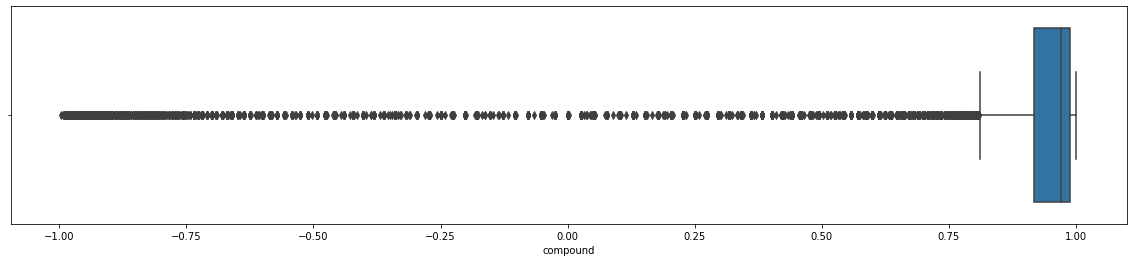

In [53]:
plt.figure(figsize=(20,4))
sns.boxplot(x=df['compound'])
plt.show()

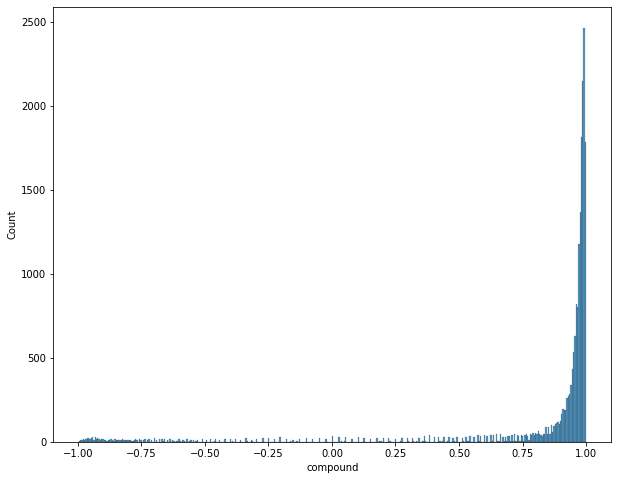

In [54]:
plt.figure(figsize=(10,8))
sns.histplot(df['compound'])
plt.show()

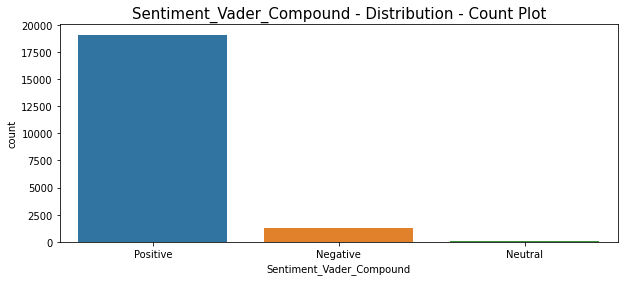

In [55]:
plt.figure(figsize=(10,4))
sns.countplot(x=df.Sentiment_Vader_Compound)
plt.title('Sentiment_Vader_Compound - Distribution - Count Plot',size=15)
plt.show()

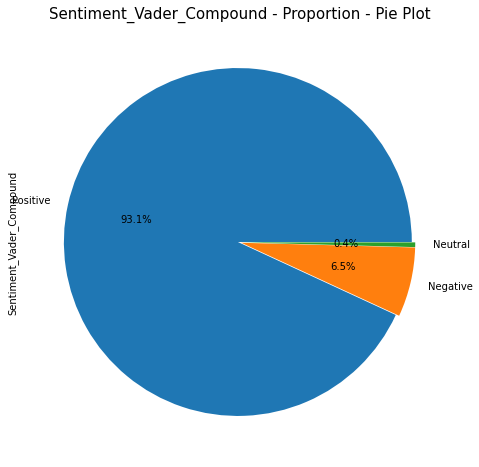

In [56]:
plt.figure(figsize=(8,8))
df.Sentiment_Vader_Compound.value_counts().plot(kind='pie',explode=[0.01,0.01,0.01],autopct='%.1f%%')
plt.title('Sentiment_Vader_Compound - Proportion - Pie Plot',size=15)
plt.show()

Sentiment Analysis using Opinion Lexicon with Spacy(Positive/Negative Dataset)

In [57]:
#Import list of positive words. Set the values as 1
positive_words = pd.read_csv('/content/positive-words.txt',header=None,encoding='latin-1')
positive_words['value']=1
positive_words.head()

,0,value
0,a+,1
1,abound,1
2,abounds,1
3,abundance,1
4,abundant,1


In [58]:
#Import list of negative words. Set the values as -1
negative_words = pd.read_csv('/content/negative-words.txt',header=None,encoding='latin-1')
negative_words['value']=-1
negative_words.head()

,0,value
0,2-faced,-1
1,2-faces,-1
2,abnormal,-1
3,abolish,-1
4,abominable,-1


In [ ]:
#Combining both positive and negative words and making it a dictionary.
positive_negative = pd.concat([positive_words,negative_words])
positive_negative_words=positive_negative.set_index(0)['value'].to_dict()
positive_negative_words

In [60]:
nlp=spacy.load('en_core_web_sm')

In [61]:
def sentiment_analysis_spacy(text: str=None):
  """
  This function gets the input string, Use pretrained model "en_core_web_sm" to preprocess the input string,
  Assign each word a sentiment value (+1 for positive words, -1 for negative words) sum it up for each sentence.
  and return the sum value.
  """
  senti_score = 0
  if text:
    sentence = nlp(text)
    for word in sentence:
      senti_score = senti_score + positive_negative_words.get(word.lemma_,0)
  return senti_score

In [62]:
sentiment_analysis_spacy('happy')

1

In [63]:
sentiment_analysis_spacy('sad')

-1

In [64]:
%%time
df['sentiment_spacy_score']=df['Lemmatized_Review'].apply(lambda x: sentiment_analysis_spacy(x))
df.head()

CPU times: user 5min 8s, sys: 1.49 s, total: 5min 10s
Wall time: 5min 9s


,Review,Rating,Rating_Analysis,Cleaned_Review,Lemmatized_Review,subjectivity,polarity,sentiment_polarity,neg,neu,pos,compound,Sentiment_Vader_Compound,sentiment_spacy_score
0,nice hotel expensive parking got good deal sta...,4.0,Positive,nice hotel expensive parking good deal stay ho...,nice hotel expensive parking good deal stay ho...,0.723158,0.229599,Positive,0.064,0.608,0.329,0.9769,Positive,5
1,ok nothing special charge diamond member hilto...,2.0,Negative,special charge diamond member hilton decided c...,special charge diamond member hilton decide ch...,0.534312,0.222302,Positive,0.049,0.735,0.216,0.9904,Positive,12
2,nice rooms not 4* experience hotel monaco seat...,3.0,Neutral,nice rooms experience hotel monaco seattle goo...,nice room experience hotel monaco seattle good...,0.598765,0.341534,Positive,0.048,0.677,0.275,0.9937,Positive,10
3,"unique, great stay, wonderful time hotel monac...",5.0,Positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,0.691228,0.504825,Positive,0.000,0.564,0.436,0.9940,Positive,14
4,"great stay great stay, went seahawk game aweso...",5.0,Positive,great stay great stay seahawk game awesome dow...,great stay great stay seahawk game awesome dow...,0.696753,0.475649,Positive,0.078,0.623,0.299,0.9929,Positive,5


In [65]:
%%time
def spacy_score(score):
  """
  This function takes sentiment_spacy_pos_neg score found from Spacy sentiment and try to classify whether the review is Positive/Negative/Neutral
  """
  if score>0:
    return('Positive')
  elif score==0:
    return('Neutral')
  else:
    return('Negative')
df['sentiment_spacy']=df['sentiment_spacy_score'].apply(spacy_score)
df.head()

CPU times: user 4.83 ms, sys: 0 ns, total: 4.83 ms
Wall time: 4.61 ms


,Review,Rating,Rating_Analysis,Cleaned_Review,Lemmatized_Review,subjectivity,polarity,sentiment_polarity,neg,neu,pos,compound,Sentiment_Vader_Compound,sentiment_spacy_score,sentiment_spacy
0,nice hotel expensive parking got good deal sta...,4.0,Positive,nice hotel expensive parking good deal stay ho...,nice hotel expensive parking good deal stay ho...,0.723158,0.229599,Positive,0.064,0.608,0.329,0.9769,Positive,5,Positive
1,ok nothing special charge diamond member hilto...,2.0,Negative,special charge diamond member hilton decided c...,special charge diamond member hilton decide ch...,0.534312,0.222302,Positive,0.049,0.735,0.216,0.9904,Positive,12,Positive
2,nice rooms not 4* experience hotel monaco seat...,3.0,Neutral,nice rooms experience hotel monaco seattle goo...,nice room experience hotel monaco seattle good...,0.598765,0.341534,Positive,0.048,0.677,0.275,0.9937,Positive,10,Positive
3,"unique, great stay, wonderful time hotel monac...",5.0,Positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,0.691228,0.504825,Positive,0.000,0.564,0.436,0.9940,Positive,14,Positive
4,"great stay great stay, went seahawk game aweso...",5.0,Positive,great stay great stay seahawk game awesome dow...,great stay great stay seahawk game awesome dow...,0.696753,0.475649,Positive,0.078,0.623,0.299,0.9929,Positive,5,Positive


In [66]:
df['sentiment_spacy_score'].describe()

count    20491.000000
mean         6.990093
std          7.175820
min        -32.000000
25%          3.000000
50%          7.000000
75%         10.000000
max         83.000000
Name: sentiment_spacy_score, dtype: float64

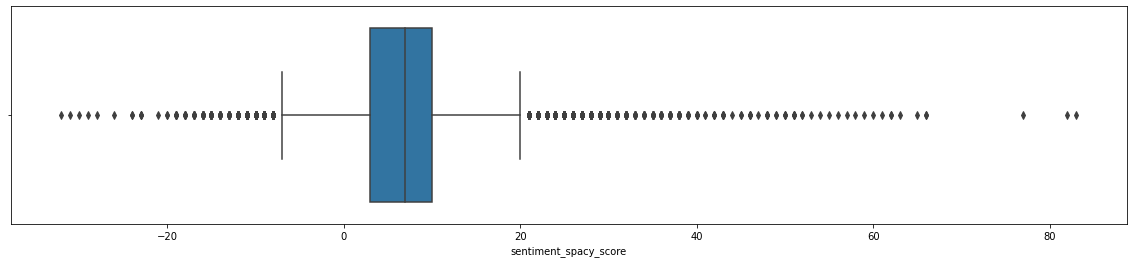

In [67]:
plt.figure(figsize=(20,4))
sns.boxplot(x=df['sentiment_spacy_score'])
plt.show()

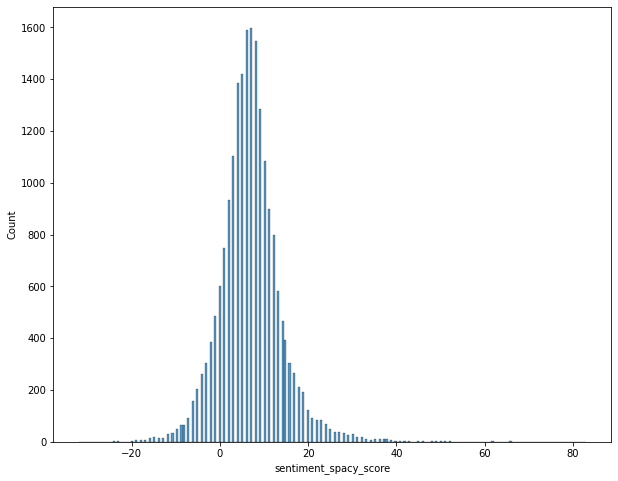

In [68]:
plt.figure(figsize=(10,8))
sns.histplot(df['sentiment_spacy_score'])
plt.show()

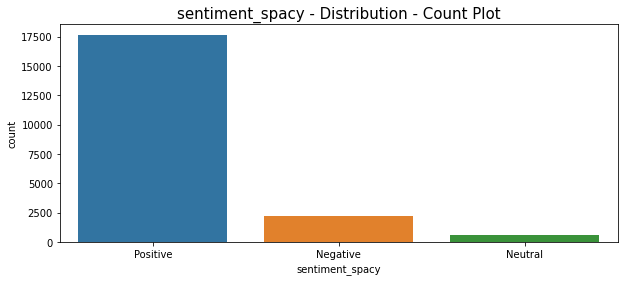

In [69]:
plt.figure(figsize=(10,4))
sns.countplot(x=df.sentiment_spacy)
plt.title('sentiment_spacy - Distribution - Count Plot',size=15)
plt.show()

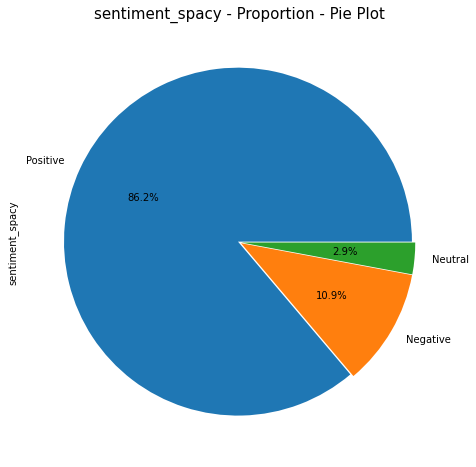

In [70]:
plt.figure(figsize=(8,8))
df.sentiment_spacy.value_counts().plot(kind='pie',explode=[0.01,0.01,0.01],autopct='%.1f%%')
plt.title('sentiment_spacy - Proportion - Pie Plot',size=15)
plt.show()

Finding Number of Characters for each Review

In [71]:
df['no_chars']=df['Lemmatized_Review'].apply(lambda x : len(x))
df.head()

,Review,Rating,Rating_Analysis,Cleaned_Review,Lemmatized_Review,subjectivity,polarity,sentiment_polarity,neg,neu,pos,compound,Sentiment_Vader_Compound,sentiment_spacy_score,sentiment_spacy,no_chars
0,nice hotel expensive parking got good deal sta...,4.0,Positive,nice hotel expensive parking good deal stay ho...,nice hotel expensive parking good deal stay ho...,0.723158,0.229599,Positive,0.064,0.608,0.329,0.9769,Positive,5,Positive,484
1,ok nothing special charge diamond member hilto...,2.0,Negative,special charge diamond member hilton decided c...,special charge diamond member hilton decide ch...,0.534312,0.222302,Positive,0.049,0.735,0.216,0.9904,Positive,12,Positive,1410
2,nice rooms not 4* experience hotel monaco seat...,3.0,Neutral,nice rooms experience hotel monaco seattle goo...,nice room experience hotel monaco seattle good...,0.598765,0.341534,Positive,0.048,0.677,0.275,0.9937,Positive,10,Positive,1197
3,"unique, great stay, wonderful time hotel monac...",5.0,Positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,0.691228,0.504825,Positive,0.000,0.564,0.436,0.9940,Positive,14,Positive,523
4,"great stay great stay, went seahawk game aweso...",5.0,Positive,great stay great stay seahawk game awesome dow...,great stay great stay seahawk game awesome dow...,0.696753,0.475649,Positive,0.078,0.623,0.299,0.9929,Positive,5,Positive,1007


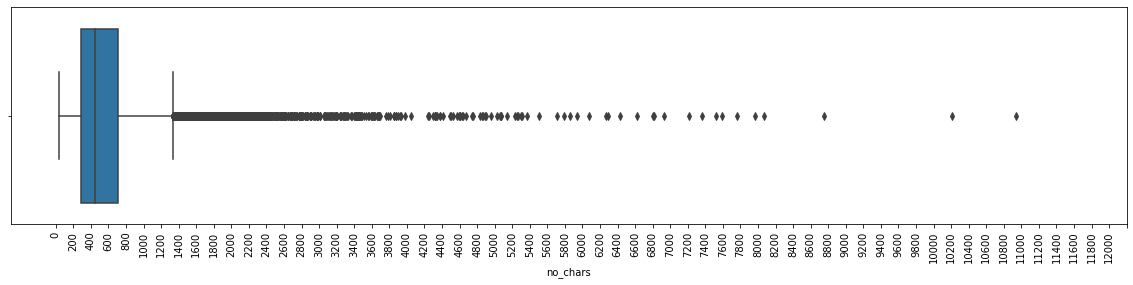

In [72]:
plt.figure(figsize=(20,4))
fig=sns.boxplot(x=df['no_chars'])
plt.xticks(np.arange(0, 12400, step=200))
fig.set_xticklabels(rotation=90,labels=(np.arange(0, 12200, step=200)))
plt.show()

In [73]:
df['no_chars'].describe().round(2)

count    20491.00
mean       592.00
std        552.38
min         32.00
25%        283.00
50%        442.00
75%        704.00
max      10938.00
Name: no_chars, dtype: float64

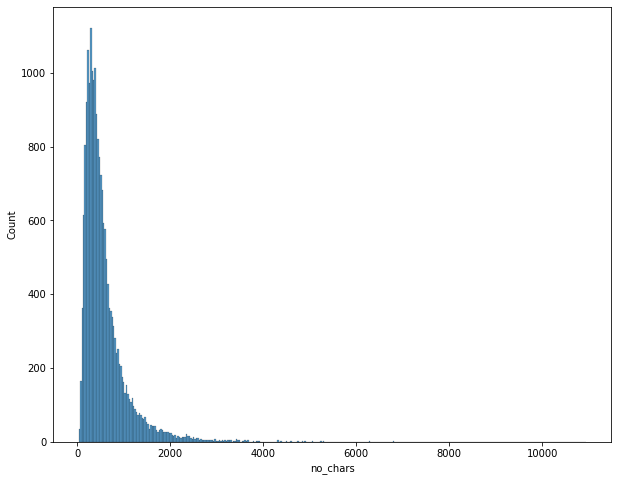

In [74]:
plt.figure(figsize=(10,8))
sns.histplot(df['no_chars'])
plt.show()

Inference on Number of Characters per Review
* Majority of the Reviews (Between 25% and 75% Quadrile) have Characters between 283 to 704
* On Average (Median), A user feeds 442 Characters for a Review
* Review with lowest number of Characters = 32
* Review with highest number of Characters = 10935
* Mean is greater than Median. Hence, Number of Characters in the Review Plot is Right/Positively Skewed.

Finding Number of Words for each Review

In [75]:
df['no_words']=df['Lemmatized_Review'].apply(lambda x : len(x.split(" ")))
df.head()

,Review,Rating,Rating_Analysis,Cleaned_Review,Lemmatized_Review,subjectivity,polarity,sentiment_polarity,neg,neu,pos,compound,Sentiment_Vader_Compound,sentiment_spacy_score,sentiment_spacy,no_chars,no_words
0,nice hotel expensive parking got good deal sta...,4.0,Positive,nice hotel expensive parking good deal stay ho...,nice hotel expensive parking good deal stay ho...,0.723158,0.229599,Positive,0.064,0.608,0.329,0.9769,Positive,5,Positive,484,73
1,ok nothing special charge diamond member hilto...,2.0,Negative,special charge diamond member hilton decided c...,special charge diamond member hilton decide ch...,0.534312,0.222302,Positive,0.049,0.735,0.216,0.9904,Positive,12,Positive,1410,205
2,nice rooms not 4* experience hotel monaco seat...,3.0,Neutral,nice rooms experience hotel monaco seattle goo...,nice room experience hotel monaco seattle good...,0.598765,0.341534,Positive,0.048,0.677,0.275,0.9937,Positive,10,Positive,1197,174
3,"unique, great stay, wonderful time hotel monac...",5.0,Positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,0.691228,0.504825,Positive,0.000,0.564,0.436,0.9940,Positive,14,Positive,523,80
4,"great stay great stay, went seahawk game aweso...",5.0,Positive,great stay great stay seahawk game awesome dow...,great stay great stay seahawk game awesome dow...,0.696753,0.475649,Positive,0.078,0.623,0.299,0.9929,Positive,5,Positive,1007,155


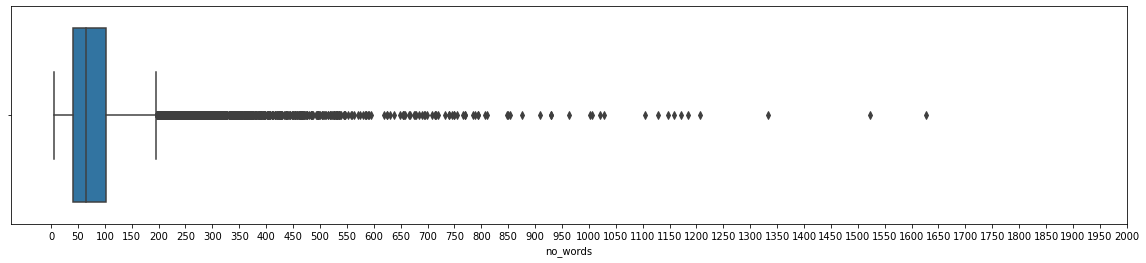

In [76]:
plt.figure(figsize=(20,4))
sns.boxplot(x=df['no_words'])
plt.xticks(np.arange(0, 2050, step=50))
plt.show()

In [77]:
df['no_words'].describe().round(3)

count    20491.000
mean        87.172
std         82.423
min          6.000
25%         41.000
50%         65.000
75%        103.000
max       1626.000
Name: no_words, dtype: float64

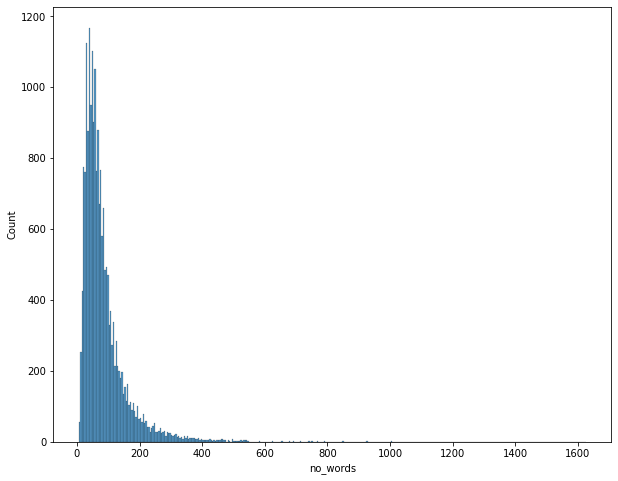

In [78]:
plt.figure(figsize=(10,8))
sns.histplot(df['no_words'])
plt.show()

Inference on Number of Words per Review
* Majority of the Reviews (Between 25% and 75% Quadrile) have words between 41 to 103
* On Average (Median), A user feeds 65 words for a Review
* Review with lowest number of words = 6
* Review with highest number of words = 1626
* Mean is greater than Median. Hence, Number of words in the Review Plot is Right/Positively Skewed.

In [79]:
df.rename(columns={'neg':'neg_senti_score','neu':'neu_senti_score','pos':'pos_senti_score'},inplace=True)
df.head()

,Review,Rating,Rating_Analysis,Cleaned_Review,Lemmatized_Review,subjectivity,polarity,sentiment_polarity,neg_senti_score,neu_senti_score,pos_senti_score,compound,Sentiment_Vader_Compound,sentiment_spacy_score,sentiment_spacy,no_chars,no_words
0,nice hotel expensive parking got good deal sta...,4.0,Positive,nice hotel expensive parking good deal stay ho...,nice hotel expensive parking good deal stay ho...,0.723158,0.229599,Positive,0.064,0.608,0.329,0.9769,Positive,5,Positive,484,73
1,ok nothing special charge diamond member hilto...,2.0,Negative,special charge diamond member hilton decided c...,special charge diamond member hilton decide ch...,0.534312,0.222302,Positive,0.049,0.735,0.216,0.9904,Positive,12,Positive,1410,205
2,nice rooms not 4* experience hotel monaco seat...,3.0,Neutral,nice rooms experience hotel monaco seattle goo...,nice room experience hotel monaco seattle good...,0.598765,0.341534,Positive,0.048,0.677,0.275,0.9937,Positive,10,Positive,1197,174
3,"unique, great stay, wonderful time hotel monac...",5.0,Positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,0.691228,0.504825,Positive,0.000,0.564,0.436,0.9940,Positive,14,Positive,523,80
4,"great stay great stay, went seahawk game aweso...",5.0,Positive,great stay great stay seahawk game awesome dow...,great stay great stay seahawk game awesome dow...,0.696753,0.475649,Positive,0.078,0.623,0.299,0.9929,Positive,5,Positive,1007,155


Rating Vs Sentiment using TextBlob Polarity

In [80]:
rating_vs_sentiment_polarity = pd.crosstab(index=df['Rating'],columns=df['sentiment_polarity'],
                                           values=df['sentiment_polarity'],aggfunc='count')
rating_vs_sentiment_polarity

sentiment_polarity,Negative,Neutral,Positive
Rating,,,
1.0,790,10,621
2.0,396,10,1387
3.0,139,6,2039
4.0,48,4,5987
5.0,49,14,8991


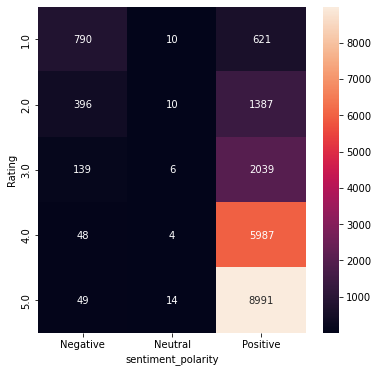

In [81]:
plt.figure(figsize=(6,6))
sns.heatmap(rating_vs_sentiment_polarity,annot=True,fmt='g')
plt.show()

In [82]:
analysis_polarity = rating_vs_sentiment_polarity
analysis_polarity['No. of Reviews']=df['Rating'].value_counts()
analysis_polarity['% Positive']=((analysis_polarity['Positive']/analysis_polarity['No. of Reviews'])*100).round(2)
analysis_polarity['% Neutral']=((analysis_polarity['Neutral']/analysis_polarity['No. of Reviews'])*100).round(2)
analysis_polarity['% Negative']=((analysis_polarity['Negative']/analysis_polarity['No. of Reviews'])*100).round(2)
analysis_polarity

sentiment_polarity,Negative,Neutral,Positive,No. of Reviews,% Positive,% Neutral,% Negative
Rating,,,,,,,
1.0,790,10,621,1421,43.70,0.70,55.59
2.0,396,10,1387,1793,77.36,0.56,22.09
3.0,139,6,2039,2184,93.36,0.27,6.36
4.0,48,4,5987,6039,99.14,0.07,0.79
5.0,49,14,8991,9054,99.30,0.15,0.54


Rating Vs Sentiment using Vader Lexicon

In [83]:
rating_vs_Sentiment_Vader_Compound = pd.crosstab(index=df['Rating'],columns=df['Sentiment_Vader_Compound'],
                                                 values=df['Sentiment_Vader_Compound'],aggfunc='count')
rating_vs_Sentiment_Vader_Compound

Sentiment_Vader_Compound,Negative,Neutral,Positive
Rating,,,
1.0,758,31,632
2.0,379,25,1389
3.0,110,13,2061
4.0,41,9,5989
5.0,35,11,9008


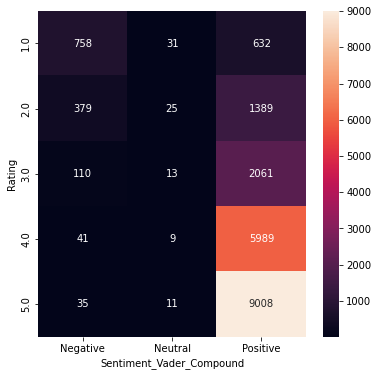

In [84]:
plt.figure(figsize=(6,6))
sns.heatmap(rating_vs_Sentiment_Vader_Compound,annot=True,fmt='g')
plt.show()

In [85]:
analysis_vader_lexicon = rating_vs_Sentiment_Vader_Compound
analysis_vader_lexicon['No. of Reviews']=df['Rating'].value_counts()
analysis_vader_lexicon['% Positive']=((analysis_vader_lexicon['Positive']/analysis_vader_lexicon['No. of Reviews'])*100).round(2)
analysis_vader_lexicon['% Neutral']=((analysis_vader_lexicon['Neutral']/analysis_vader_lexicon['No. of Reviews'])*100).round(2)
analysis_vader_lexicon['% Negative']=((analysis_vader_lexicon['Negative']/analysis_vader_lexicon['No. of Reviews'])*100).round(2)
analysis_vader_lexicon

Sentiment_Vader_Compound,Negative,Neutral,Positive,No. of Reviews,% Positive,% Neutral,% Negative
Rating,,,,,,,
1.0,758,31,632,1421,44.48,2.18,53.34
2.0,379,25,1389,1793,77.47,1.39,21.14
3.0,110,13,2061,2184,94.37,0.60,5.04
4.0,41,9,5989,6039,99.17,0.15,0.68
5.0,35,11,9008,9054,99.49,0.12,0.39


Rating Vs Sentiment using Opinion Lexicon with Spacy

In [86]:
rating_vs_sentiment_spacy = pd.crosstab(index=df['Rating'],columns=df['sentiment_spacy'],
                                           values=df['sentiment_spacy'],aggfunc='count')
rating_vs_sentiment_spacy

sentiment_spacy,Negative,Neutral,Positive
Rating,,,
1.0,1002,119,300
2.0,735,156,902
3.0,250,131,1803
4.0,155,106,5778
5.0,90,89,8875


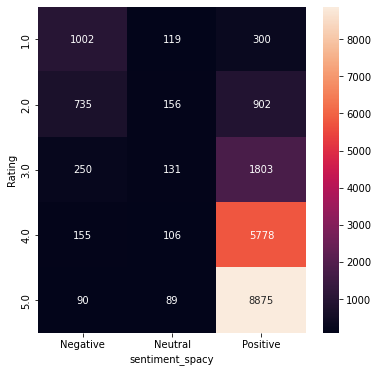

In [87]:
plt.figure(figsize=(6,6))
sns.heatmap(rating_vs_sentiment_spacy,annot=True,fmt='g')
plt.show()

In [88]:
analysis_spacy = rating_vs_sentiment_spacy
analysis_spacy['No. of Reviews']=df['Rating'].value_counts()
analysis_spacy['% Positive']=((analysis_spacy['Positive']/analysis_spacy['No. of Reviews'])*100).round(2)
analysis_spacy['% Neutral']=((analysis_spacy['Neutral']/analysis_spacy['No. of Reviews'])*100).round(2)
analysis_spacy['% Negative']=((analysis_spacy['Negative']/analysis_spacy['No. of Reviews'])*100).round(2)
analysis_spacy

sentiment_spacy,Negative,Neutral,Positive,No. of Reviews,% Positive,% Neutral,% Negative
Rating,,,,,,,
1.0,1002,119,300,1421,21.11,8.37,70.51
2.0,735,156,902,1793,50.31,8.70,40.99
3.0,250,131,1803,2184,82.55,6.00,11.45
4.0,155,106,5778,6039,95.68,1.76,2.57
5.0,90,89,8875,9054,98.02,0.98,0.99


Most Positive  Review

In [89]:
df_positive=df[df['no_words']>100].sort_values("sentiment_spacy_score",ascending=False)[["Lemmatized_Review","Rating","sentiment_spacy_score"]]
df_positive.head(1)

,Lemmatized_Review,Rating,sentiment_spacy_score
18917,ocean blue excellent resort boyfriend stay oce...,5.0,83


In [90]:
df['Review'][18917]

'ocean blue excellent resort, boyfriend mid-20__Ç_é_ stayed ocean blue 6 days week june, awesome time relaxation beach ocean fruity frosty drinks, booked trip left read ocean blue reviews faithfully, little concerned negative reviews figured we__Ç_éö, think value ocean blue excellent booked hotel apple flight separately usa3000 ocean blue 57 day, reading reviews main complaints time food friendliness staff, travelers generally pretty happy hotel/grounds pools/beach rooms drinks, thing like note future ocean blue-goers all-inclusive travelers general all-inclusive resorts generally masses, tropical locale pretty inexpensive generally newer clean food drinks you__Ç_éö basic tgi friday__Ç_é_/outback/olive garden/etc, decent food price somewhat mass-produced, you__Ç_éÈe paying night hotel beach food alcohol activities you__Ç_éö paying nice meal high-end restaurant, saying goes pay not expect morton__Ç_é_ steakhouse meals not paying, advice i__Ç_é_x0096_ sure you__Ç_éêl enjoy review__Ç br/ 

In [91]:
df.loc[18917]

Review                      ocean blue excellent resort, boyfriend mid-20_...
Rating                                                                    5.0
Rating_Analysis                                                      Positive
Cleaned_Review              ocean blue excellent resort boyfriend stayed o...
Lemmatized_Review           ocean blue excellent resort boyfriend stay oce...
subjectivity                                                         0.545851
polarity                                                             0.306378
sentiment_polarity                                                   Positive
neg_senti_score                                                         0.056
neu_senti_score                                                         0.614
pos_senti_score                                                         0.331
compound                                                               0.9998
Sentiment_Vader_Compound                                        

Most Negative Review

In [92]:
df_negative=df[df['no_words']>100].sort_values("sentiment_spacy_score",ascending=True)[["Lemmatized_Review","Rating","sentiment_spacy_score"]]
df_negative.head(1)

,Lemmatized_Review,Rating,sentiment_spacy_score
18127,learn lesson major disappointment online servi...,1.0,-32


In [93]:
df['Review'][18127]

"learned lesson major disappointment used online service booked ramada limited tukwila attributes hotel general location not pay non-refundable numerous times years, satisfied, experience changed travel reservation habits forever, dissatisfaction does n't begin experience, stunned like it.there large confusion seattle ramadas, 4 5, called inn, ramada inn suites near sea-tac, place talking ramada limited tukwila, book hotel knowing, stay ramada, just fact facility scares me.i stayed nights wanted run hour arriving stuck paid late, van picked old did n't look business-like upholstery stained, 2 miles north sea-tac old pacific highway run-down/transitional neighborhood, casinos smoke rooms area, miles north ramada inn suites october confused review, arrival group 6 7 unsavory scary looking characters hanging corner 139th just arriving, feet door.i walked lobby night getting medical conference marriott-seatac lobby small court-tv blast lobby, lobby look decay old dusty fake flowers unhealt

In [94]:
df.loc[18127]

Review                      learned lesson major disappointment used onlin...
Rating                                                                    1.0
Rating_Analysis                                                      Negative
Cleaned_Review              learned lesson major disappointment online ser...
Lemmatized_Review           learn lesson major disappointment online servi...
subjectivity                                                         0.655379
polarity                                                            -0.258355
sentiment_polarity                                                   Negative
neg_senti_score                                                         0.216
neu_senti_score                                                         0.709
pos_senti_score                                                         0.075
compound                                                              -0.9892
Sentiment_Vader_Compound                                        

N - Gram

In [95]:
def get_top_n_words(df,n=None,ngram=None):
  """
  This function takes review as input and provide most frequent Bi-Gram or Tri-Gram Words.
  """
  vect_n_grams=CountVectorizer(max_features=2000,ngram_range=ngram).fit(df)
  bag_of_words=vect_n_grams.transform(df)
  sum_of_words=bag_of_words.sum(axis=0)
  word_frequency=[(word,sum_of_words[0,idx]) for word,idx in vect_n_grams.vocabulary_.items()]
  word_frequency=sorted(word_frequency,key=lambda x : x[1],reverse=True)
  return word_frequency[:n]

Bi-Gram

In [96]:
df_pos = df[df['sentiment_spacy']=='Positive']
df_neg = df[df['sentiment_spacy']=='Negative']

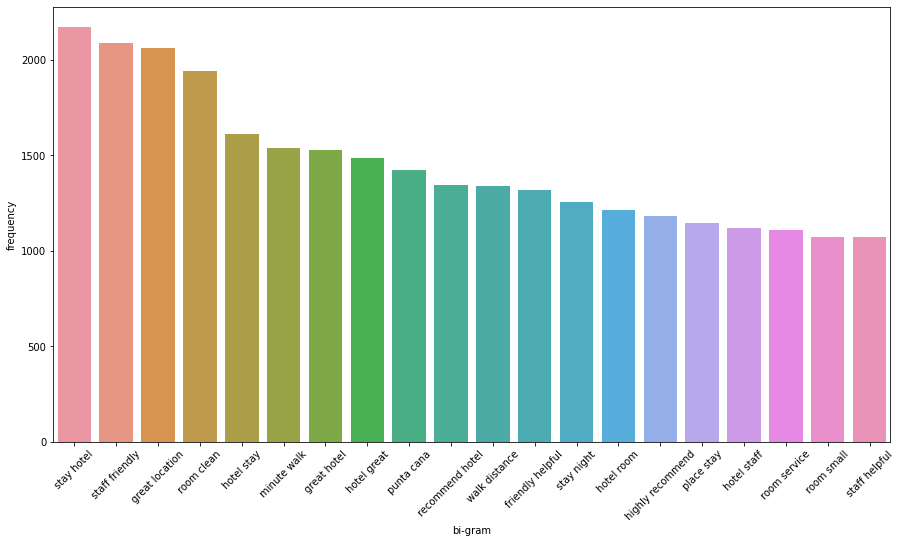

In [97]:
top_20_pos_bigram=get_top_n_words(df_pos['Lemmatized_Review'],n=20,ngram=(2,2))
top_20_pos_bigram=pd.DataFrame(top_20_pos_bigram,columns=['bi-gram','frequency'])
plt.figure(figsize=(15,8))
fig=sns.barplot(x='bi-gram',y='frequency',data=top_20_pos_bigram)
fig.set_xticklabels(rotation=45,labels=top_20_pos_bigram['bi-gram'])
plt.show()


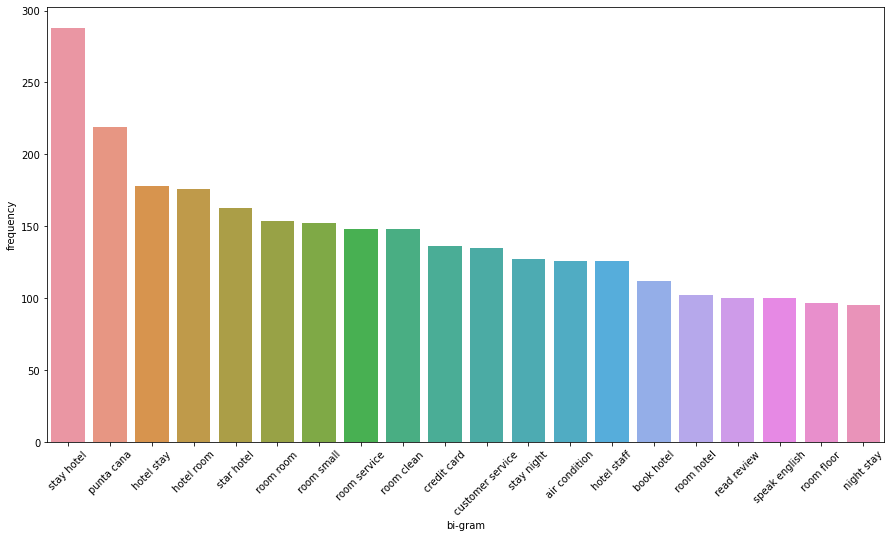

In [98]:
top_20_neg_bigram=get_top_n_words(df_neg['Lemmatized_Review'],n=20,ngram=(2,2))
top_20_neg_bigram=pd.DataFrame(top_20_neg_bigram,columns=['bi-gram','frequency'])
plt.figure(figsize=(15,8))
fig=sns.barplot(x='bi-gram',y='frequency',data=top_20_neg_bigram)
fig.set_xticklabels(rotation=45,labels=top_20_neg_bigram['bi-gram'])
plt.show()

Tri Gram

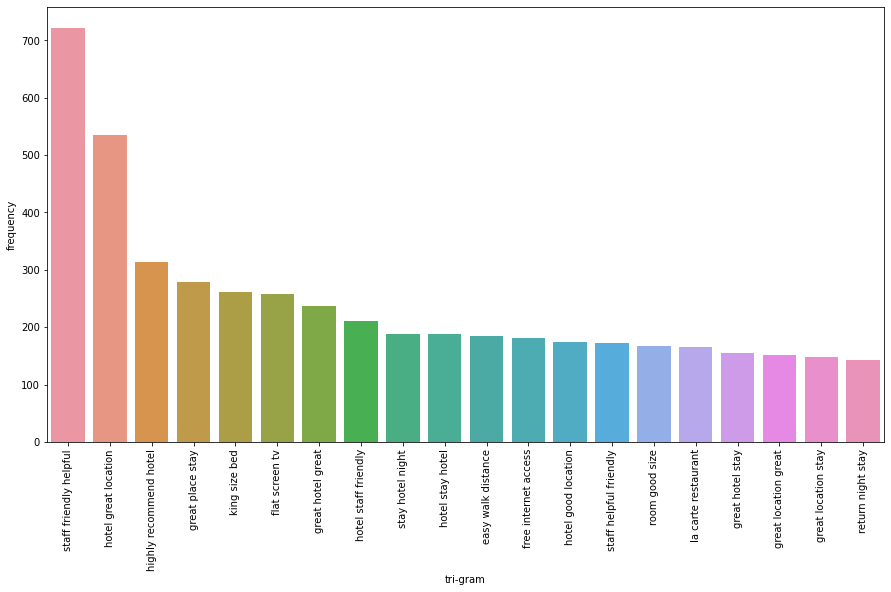

In [99]:
top_20_pos_trigram=get_top_n_words(df_pos['Lemmatized_Review'],n=20,ngram=(3,3))
top_20_pos_trigram=pd.DataFrame(top_20_pos_trigram,columns=['tri-gram','frequency'])
plt.figure(figsize=(15,8))
fig=sns.barplot(x='tri-gram',y='frequency',data=top_20_pos_trigram)
fig.set_xticklabels(rotation=90,labels=top_20_pos_trigram['tri-gram'])
plt.show()

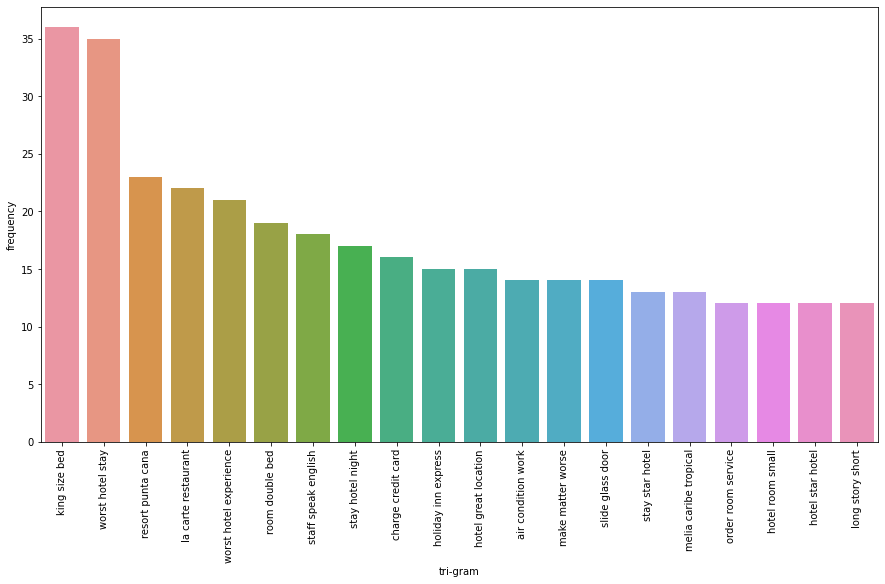

In [100]:
top_20_neg_trigram=get_top_n_words(df_neg['Lemmatized_Review'],n=20,ngram=(3,3))
top_20_neg_trigram=pd.DataFrame(top_20_neg_trigram,columns=['tri-gram','frequency'])
plt.figure(figsize=(15,8))
fig=sns.barplot(x='tri-gram',y='frequency',data=top_20_neg_trigram)
fig.set_xticklabels(rotation=90,labels=top_20_neg_trigram['tri-gram'])
plt.show()

Word Cloud

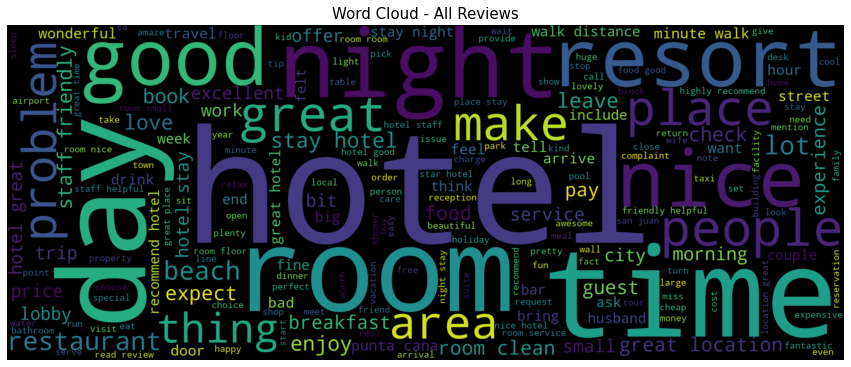

In [101]:
#From complete Reviews
string = " ".join(df['Lemmatized_Review'])
word_cloud = WordCloud(width=2500,height=1000).generate(string)
plt.figure(figsize=(15,15))
plt.imshow(word_cloud,interpolation='bilinear')
plt.title('Word Cloud - All Reviews',size=15)
plt.axis('off')
plt.show()

In [102]:
def positive_negative(txt):
  """
  This function takes text string as input and get only words that are having below pos tags
  ['JJ','JJR','JJS','NNP','NNPS','RB','RBR','RBS','VB','VBD','VBG','VBN','VBP','VBZ']
  """
  list_review=[wrd if tag in ['JJ','JJR','JJS','NNP','NNPS','RB','RBR','RBS','VB','VBD','VBG','VBN','VBP','VBZ'] else '' for wrd, tag in pos_tag(w_tokenizer.tokenize(txt))]
  return (' '.join([x for x in list_review if x]))

In [103]:
df['pos_tags_words'] = df['Lemmatized_Review'].apply(lambda x: positive_negative(x))
df.head()

,Review,Rating,Rating_Analysis,Cleaned_Review,Lemmatized_Review,subjectivity,polarity,sentiment_polarity,neg_senti_score,neu_senti_score,pos_senti_score,compound,Sentiment_Vader_Compound,sentiment_spacy_score,sentiment_spacy,no_chars,no_words,pos_tags_words
0,nice hotel expensive parking got good deal sta...,4.0,Positive,nice hotel expensive parking good deal stay ho...,nice hotel expensive parking good deal stay ho...,0.723158,0.229599,Positive,0.064,0.608,0.329,0.9769,Positive,5,Positive,484,73,nice expensive good stay anniversary arrive la...
1,ok nothing special charge diamond member hilto...,2.0,Negative,special charge diamond member hilton decided c...,special charge diamond member hilton decide ch...,0.534312,0.222302,Positive,0.049,0.735,0.216,0.9904,Positive,12,Positive,1410,205,special shot anniversary seattle suite extra w...
2,nice rooms not 4* experience hotel monaco seat...,3.0,Neutral,nice rooms experience hotel monaco seattle goo...,nice room experience hotel monaco seattle good...,0.598765,0.341534,Positive,0.048,0.677,0.275,0.9937,Positive,10,Positive,1197,174,nice seattle good large comfortable pillowsatt...
3,"unique, great stay, wonderful time hotel monac...",5.0,Positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,0.691228,0.504825,Positive,0.000,0.564,0.436,0.9940,Positive,14,Positive,523,80,unique great wonderful excellent short main fr...
4,"great stay great stay, went seahawk game aweso...",5.0,Positive,great stay great stay seahawk game awesome dow...,great stay great stay seahawk game awesome dow...,0.696753,0.475649,Positive,0.078,0.623,0.299,0.9929,Positive,5,Positive,1007,155,great great seahawk awesome build huge helpful...


In [104]:
positive_wordcloud=df[df['sentiment_spacy']=='Positive']['pos_tags_words']
positive_wordcloud

0        nice expensive good stay anniversary arrive la...
1        special shot anniversary seattle suite extra w...
2        nice seattle good large comfortable pillowsatt...
3        unique great wonderful excellent short main fr...
4        great great seahawk awesome build huge helpful...
                               ...                        
20483    good clean happy even courteous bed comfortabl...
20486    secret stay beat stay esteem bw crowd leisure ...
20487    great great quick sightsdirectly street needle...
20488    nice modern friendly corridor dark good pulled...
20490    talk excellent patricia extremely helpful flue...
Name: pos_tags_words, Length: 17658, dtype: object

In [105]:
negative_wordcloud=df[df['sentiment_spacy']=='Negative']['pos_tags_words']
negative_wordcloud

15       horrible stay february pick website online inc...
32       noise airconditionera standard warwick seattle...
42       warwick bad good rude fairly dirty bandaid req...
44       austin familiar seattlewhere clean ask brought...
54       expensive simple simply unbeatable mere great ...
                               ...                        
20474    bad terrible noisy nearby hang greatest nice s...
20481    run average chose expensive roombed reserved u...
20484    deceptive deceptive completely true free seatt...
20485    impressed unfriendly check higher highest tell...
20489    ruin open guest happy stumble apt gobcn unexpe...
Name: pos_tags_words, Length: 2232, dtype: object

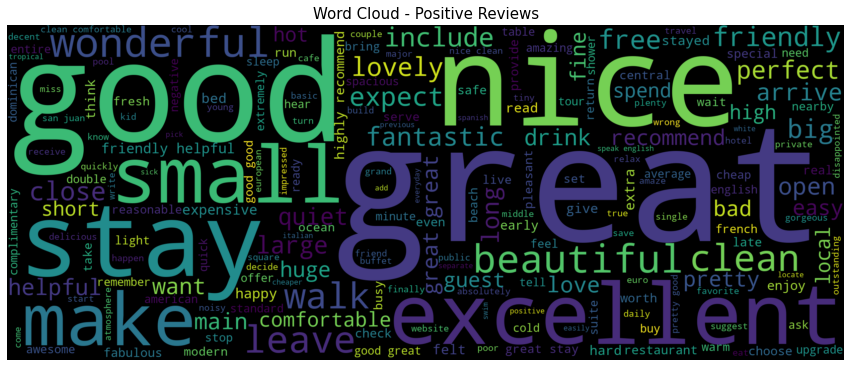

In [106]:
#From Positive Reviews
string = " ".join(positive_wordcloud)
word_cloud = WordCloud(width=2500,height=1000).generate(string)
plt.figure(figsize=(15,15))
plt.imshow(word_cloud,interpolation='bilinear')
plt.title('Word Cloud - Positive Reviews',size=15)
plt.axis('off')
plt.show()

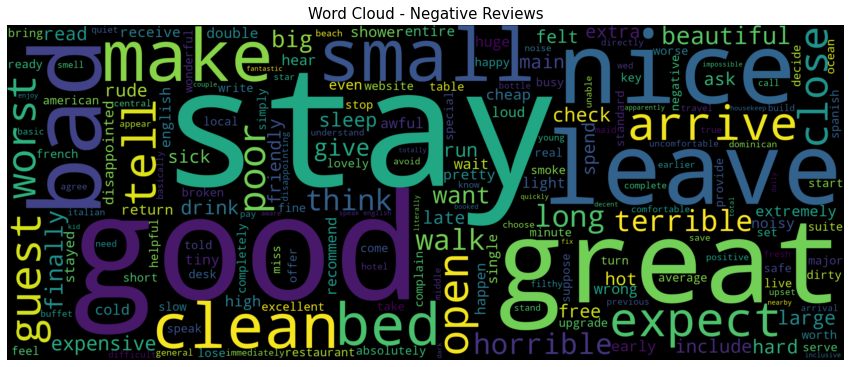

In [107]:
#From Negative Reviews
string = " ".join(negative_wordcloud)
word_cloud = WordCloud(width=2500,height=1000).generate(string)
plt.figure(figsize=(15,15))
plt.imshow(word_cloud,interpolation='bilinear')
plt.title('Word Cloud - Negative Reviews',size=15)
plt.axis('off')
plt.show()